## 评分卡模型开发步骤：
* Step1，数据获取，包括获取存量客户及潜在客户的数据<br/>
存量客户，已开展融资业务的客户，包括个人客户和机构客户；<br/>
潜在客户，将要开展业务的客户<br/>
* Step2，EDA，获取样本整体情况，进行直方图、箱形图可视化
* Step3，数据预处理，包括数据清洗、缺失值处理、异常值处理
* Step4，变量筛选，通过统计学的方法，筛选出对违约状态影响最显著的指标。主要有单变量特征选择和基于机器学习的方法
* Step5，模型开发，包括变量分段、变量的WOE（证据权重）变换和逻辑回归估算三个部分
* Step6，模型评估，评估模型的区分能力、预测能力、稳定性，并形成模型评估报告，得出模型是否可以使用的结论
* Step7，生成评分卡（信用评分），根据逻辑回归的系数和WOE等确定信用评分的方法，将Logistic模型转换为标准评分的形式
* Step8，建立评分系统（布置上线），根据生成的评分卡，建立自动信用评分系统

## WOE和IV计算步骤：
* Step1，对于连续型变量，进行分箱（binning），可以选择等频、等距，或者自定义间隔，对于离散型变量，如果分箱太多，则进行分箱合并
* Step2，统计每个分箱里的好人数(bin_goods)和坏人数(bin_bads)
* Step3，分别除以总的好人数(total_goods)和坏人数(total_bads)，得到每个分箱内的边际好人占比margin_good_rate和边际坏人比margin_bad_rate
* Step4，计算每个分箱的WOE
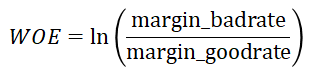<br/>
* Step5，检查每个分箱（除null分箱外）里WOE值是否满足单调性，若不满足，返回step1<br/>
说明：null分箱由于有明确的业务解释，因此不需要考虑满足单调性
* Step6，计算每个分箱里的IV，最终求和，即得到最终的IV


Project：基于评分卡的风控模型开发<br/>
数据集GiveMeSomeCredit，15万样本数据<br/>
https://www.kaggle.com/c/GiveMeSomeCredit/data<br/>
– 基本属性：包括了借款人当时的年龄<br/>
– 偿债能力：包括了借款人的月收入、负债比率<br/>
– 信用往来：两年内35-59天逾期次数、两年内60-89天逾期次数、两年内90天或高于90天逾期的次数<br/>
– 财产状况：包括了开放式信贷和贷款数量、不动产贷款或额度数量。<br/>
– 其他因素：包括了借款人的家属数量<br/>
– 时间窗口：自变量的观察窗口为过去两年，因变量表现窗口为未来两年

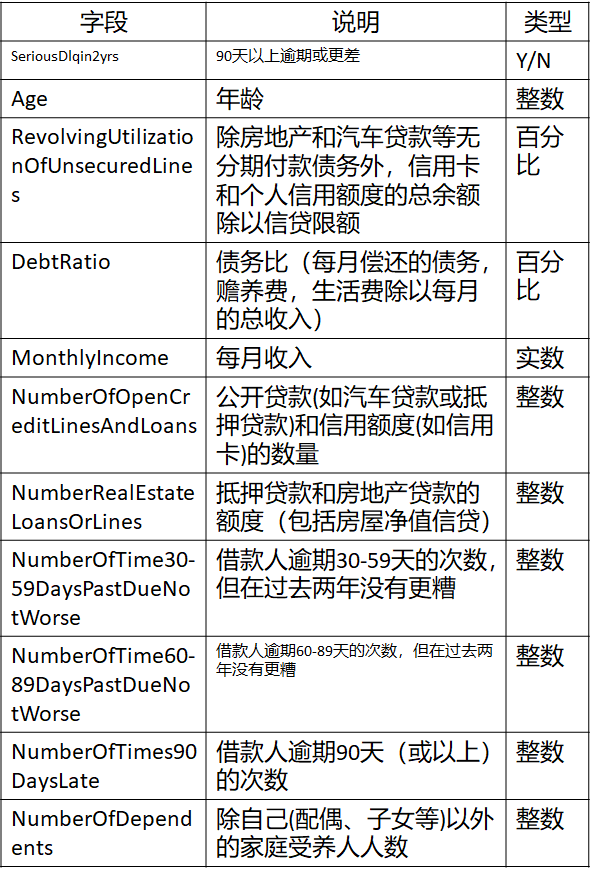

## Project 基于评分卡的风控模型开发：
* Step1，数据探索性分析<br/>
违约率分析<br/>
缺失值分析<br/>
对于某个字段的统计分析（比如RevolvingUtilizationOfUnsecuredLines）<br/>
* Step2，数据缺失值填充，采用简单规则，如使用中位数进行填充<br/>
* Step3，变量分箱<br/>
* 1）对于age字段，分成6段 [-math.inf, 25, 40, 50, 60, 70, math.inf]<br/>
* 2）对于NumberOfDependents（家属人数）字段，分成6段<br/>
 [-math.inf,2,4,6,8,10,math.inf]<br/>
* 3）对于3种逾期次数，即NumberOfTime30-59DaysPastDueNotWorse，NumberOfTime60-89DaysPastDueNotWorse，NumberOfTimes90DaysLate，分成10段<br/>
[-math.inf,1,2,3,4,5,6,7,8,9,math.inf]<br/>
* 4）对于其余字段，即RevolvingUtilizationOfUnsecuredLines, DebtRatio, MonthlyIncome, NumberOfOpenCreditLinesAndLoans, NumberRealEstateLoansOrLines 分成5段<br/>
* Step4，特征筛选<br/>
使用IV值衡量自变量的预测能力，筛选IV值>0.1的特征字段<br/>
* Step5，对于筛选出来的特征，计算每个bin的WOE值<br/>
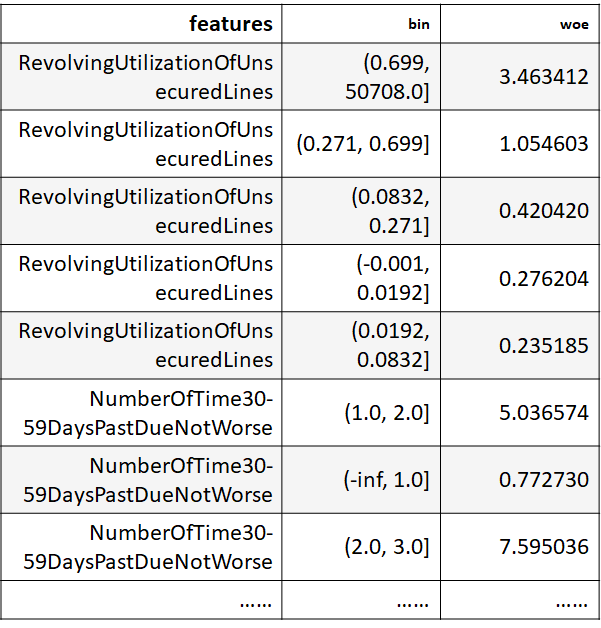<br/>
* Step6，使用逻辑回归进行建模<br/>
训练集、测试集切分<br/>
计算LR的准确率<br/>
* Step7，评分卡模型转换<br/>
设p为客户违约的概率，那么正常的概率为1-p<br/>
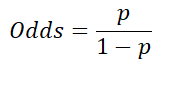<br/>
客户违约概率p可以表示<br/>
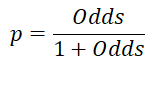<br/>
评分卡的分值计算，可以通过 分值表示为比率对数的线性表达式来定义，即<br/>
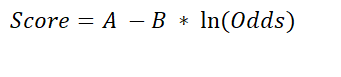<br/>
Score计算公式类似 y=kx + b ，A和B是常数，A称为“补偿”，B称为“刻度”，公式中的负号可以使得违约概率越低，得分越高<br/>
常数A、B可以通过将两个假设的分值带入计算得到：<br/>
* 1）基准分，即给某个特定的比率时，预期的分值为<br/>
通常，业内的基准分为500/600/650<br/>
* 2）PDO（ point of double odds ），即比率翻倍的分数<br/>
比如，odds翻倍时，分值减少50<br/>
比率为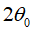的点的分值应该为<br/>
代入式中，可以得到：<br/>
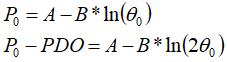<br/>
求解得：<br/>
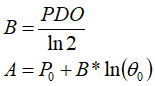<br/>
假设odds=1的时候，特定的分数为650分<br/>
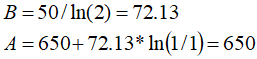<br/>
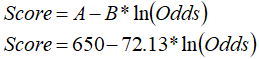<br/>
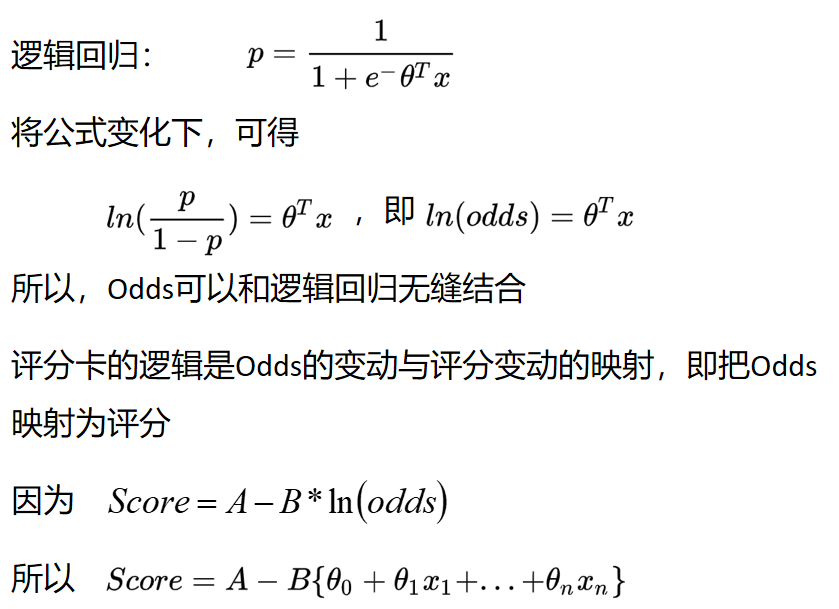

In [1]:
import pandas as pd
# 数据加载
df_train = pd.read_csv('./cs-training.csv')
df_train

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
149995,149996,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,149997,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,149998,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,149999,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


In [2]:
#去掉第一列
df_train = df_train.iloc[:,1:]
df_train

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149995,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


In [3]:
df_train['SeriousDlqin2yrs'].value_counts()

0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64

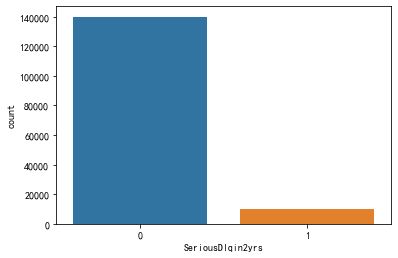

In [4]:
# 对违约率SeriousDlqin2yrs进行可视化
import seaborn as sns
sns.countplot(x='SeriousDlqin2yrs',data=df_train)

In [5]:
# 求0和1的比例，即违约比例
df_train['SeriousDlqin2yrs'].sum()/len(df_train)

0.06684

In [6]:
df_train.isnull().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [7]:
df_train['RevolvingUtilizationOfUnsecuredLines'].describe()

count    150000.000000
mean          6.048438
std         249.755371
min           0.000000
25%           0.029867
50%           0.154181
75%           0.559046
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

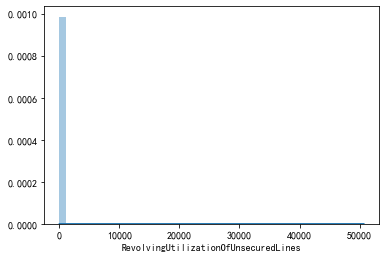

In [8]:
# 直方图分布
sns.distplot(df_train['RevolvingUtilizationOfUnsecuredLines'])

由上图可知直方图分布比较明显，取值范围比较集中都是在最开始，后面很稀疏

In [9]:
df_train.mean()

SeriousDlqin2yrs                           0.066840
RevolvingUtilizationOfUnsecuredLines       6.048438
age                                       52.295207
NumberOfTime30-59DaysPastDueNotWorse       0.421033
DebtRatio                                353.005076
MonthlyIncome                           6670.221237
NumberOfOpenCreditLinesAndLoans            8.452760
NumberOfTimes90DaysLate                    0.265973
NumberRealEstateLoansOrLines               1.018240
NumberOfTime60-89DaysPastDueNotWorse       0.240387
NumberOfDependents                         0.757222
dtype: float64

In [10]:
df_train.median()

SeriousDlqin2yrs                           0.000000
RevolvingUtilizationOfUnsecuredLines       0.154181
age                                       52.000000
NumberOfTime30-59DaysPastDueNotWorse       0.000000
DebtRatio                                  0.366508
MonthlyIncome                           5400.000000
NumberOfOpenCreditLinesAndLoans            8.000000
NumberOfTimes90DaysLate                    0.000000
NumberRealEstateLoansOrLines               1.000000
NumberOfTime60-89DaysPastDueNotWorse       0.000000
NumberOfDependents                         0.000000
dtype: float64

In [11]:
# 使用中位数的方式填充缺失值
df_train = df_train.fillna(df_train.median())
df_train.isnull().sum()

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

In [12]:
# 数据分箱
import math

# 将age字段进行分箱
age_bins = [-math.inf, 25, 40, 50, 60, 70, math.inf]
df_train['bin_age'] = pd.cut(df_train['age'],bins=age_bins)
df_train[['age','bin_age']]

,age,bin_age
0,45,"(40.0, 50.0]"
1,40,"(25.0, 40.0]"
2,38,"(25.0, 40.0]"
3,30,"(25.0, 40.0]"
4,49,"(40.0, 50.0]"
...,...,...
149995,74,"(70.0, inf]"
149996,44,"(40.0, 50.0]"
149997,58,"(50.0, 60.0]"
149998,30,"(25.0, 40.0]"


In [13]:
#对于NumberOfDependents（家属人数）字段，分成6段
dependents_bins = [-math.inf,2,4,6,8,10,math.inf]
df_train['bin_NumberOfDependents'] = pd.cut(df_train['NumberOfDependents'],bins=dependents_bins)
df_train[['NumberOfDependents','bin_NumberOfDependents']]

,NumberOfDependents,bin_NumberOfDependents
0,2.0,"(-inf, 2.0]"
1,1.0,"(-inf, 2.0]"
2,0.0,"(-inf, 2.0]"
3,0.0,"(-inf, 2.0]"
4,0.0,"(-inf, 2.0]"
...,...,...
149995,0.0,"(-inf, 2.0]"
149996,2.0,"(-inf, 2.0]"
149997,0.0,"(-inf, 2.0]"
149998,0.0,"(-inf, 2.0]"


In [14]:
# 对于3种逾期次数，即NumberOfTime30-59DaysPastDueNotWorse，NumberOfTime60-89DaysPastDueNotWorse，NumberOfTimes90DaysLate，分成10段
dpd_bins = [-math.inf,1,2,3,4,5,6,7,8,9,math.inf]
df_train['bin_NumberOfTime30-59DaysPastDueNotWorse'] = pd.cut(df_train['NumberOfTime30-59DaysPastDueNotWorse'],bins=dpd_bins)
df_train['bin_NumberOfTime60-89DaysPastDueNotWorse'] = pd.cut(df_train['NumberOfTime60-89DaysPastDueNotWorse'],bins=dpd_bins)
df_train['bin_NumberOfTimes90DaysLate'] = pd.cut(df_train['NumberOfTimes90DaysLate'],bins=dpd_bins)
df_train[['NumberOfTime30-59DaysPastDueNotWorse','bin_NumberOfTime30-59DaysPastDueNotWorse','NumberOfTime60-89DaysPastDueNotWorse',\
         'bin_NumberOfTime60-89DaysPastDueNotWorse','NumberOfTimes90DaysLate','bin_NumberOfTimes90DaysLate']]


,NumberOfTime30-59DaysPastDueNotWorse,bin_NumberOfTime30-59DaysPastDueNotWorse,NumberOfTime60-89DaysPastDueNotWorse,bin_NumberOfTime60-89DaysPastDueNotWorse,NumberOfTimes90DaysLate,bin_NumberOfTimes90DaysLate
0,2,"(1.0, 2.0]",0,"(-inf, 1.0]",0,"(-inf, 1.0]"
1,0,"(-inf, 1.0]",0,"(-inf, 1.0]",0,"(-inf, 1.0]"
2,1,"(-inf, 1.0]",0,"(-inf, 1.0]",1,"(-inf, 1.0]"
3,0,"(-inf, 1.0]",0,"(-inf, 1.0]",0,"(-inf, 1.0]"
4,1,"(-inf, 1.0]",0,"(-inf, 1.0]",0,"(-inf, 1.0]"
...,...,...,...,...,...,...
149995,0,"(-inf, 1.0]",0,"(-inf, 1.0]",0,"(-inf, 1.0]"
149996,0,"(-inf, 1.0]",0,"(-inf, 1.0]",0,"(-inf, 1.0]"
149997,0,"(-inf, 1.0]",0,"(-inf, 1.0]",0,"(-inf, 1.0]"
149998,0,"(-inf, 1.0]",0,"(-inf, 1.0]",0,"(-inf, 1.0]"


In [15]:
df_train['MonthlyIncome'].value_counts()
# df_train.shape # 15万的数据及，每段应该是3万 所以5400 这一行 有62个超了 需要drop（与下面的5000合并到一起）

5400.0     30062
5000.0      2757
4000.0      2106
6000.0      1934
3000.0      1758
           ...  
3847.0         1
10113.0        1
14210.0        1
13023.0        1
1037.0         1
Name: MonthlyIncome, Length: 13594, dtype: int64

In [16]:
df_train['NumberRealEstateLoansOrLines'].value_counts()

0     56188
1     52338
2     31522
3      6300
4      2170
5       689
6       320
7       171
8        93
9        78
10       37
11       23
12       18
13       15
14        7
15        7
16        4
17        4
25        3
18        2
19        2
20        2
23        2
32        1
21        1
26        1
29        1
54        1
Name: NumberRealEstateLoansOrLines, dtype: int64

In [17]:
# 对于其余字段，即RevolvingUtilizationOfUnsecuredLines, DebtRatio, MonthlyIncome, NumberOfOpenCreditLinesAndLoans, NumberRealEstateLoansOrLines 分成5段
df_train['bin_RevolvingUtilizationOfUnsecuredLines'] = pd.qcut(df_train['RevolvingUtilizationOfUnsecuredLines'],q=5,duplicates='drop')
df_train['bin_DebtRatio'] = pd.qcut(df_train['DebtRatio'],q=5,duplicates='drop')
df_train['bin_MonthlyIncome'] = pd.qcut(df_train['MonthlyIncome'],q=5,duplicates='drop')
df_train['bin_NumberOfOpenCreditLinesAndLoans'] = pd.qcut(df_train['NumberOfOpenCreditLinesAndLoans'],q=5,duplicates='drop')
loans_bins = [-math.inf,0,1,2,3,math.inf]
#df_train['bin_NumberRealEstateLoansOrLines'] = pd.qcut(df_train['NumberRealEstateLoansOrLines'],q=5,duplicates='drop')
df_train['bin_NumberRealEstateLoansOrLines'] = pd.cut(df_train['NumberRealEstateLoansOrLines'],bins=loans_bins)
df_train


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,...,bin_age,bin_NumberOfDependents,bin_NumberOfTime30-59DaysPastDueNotWorse,bin_NumberOfTime60-89DaysPastDueNotWorse,bin_NumberOfTimes90DaysLate,bin_RevolvingUtilizationOfUnsecuredLines,bin_DebtRatio,bin_MonthlyIncome,bin_NumberOfOpenCreditLinesAndLoans,bin_NumberRealEstateLoansOrLines
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,...,"(40.0, 50.0]","(-inf, 2.0]","(1.0, 2.0]","(-inf, 1.0]","(-inf, 1.0]","(0.699, 50708.0]","(0.468, 4.0]","(8250.0, 3008750.0]","(12.0, 58.0]","(3.0, inf]"
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,...,"(25.0, 40.0]","(-inf, 2.0]","(-inf, 1.0]","(-inf, 1.0]","(-inf, 1.0]","(0.699, 50708.0]","(-0.001, 0.134]","(-0.001, 3400.0]","(-0.001, 4.0]","(-inf, 0.0]"
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,...,"(25.0, 40.0]","(-inf, 2.0]","(-inf, 1.0]","(-inf, 1.0]","(-inf, 1.0]","(0.271, 0.699]","(-0.001, 0.134]","(-0.001, 3400.0]","(-0.001, 4.0]","(-inf, 0.0]"
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,...,"(25.0, 40.0]","(-inf, 2.0]","(-inf, 1.0]","(-inf, 1.0]","(-inf, 1.0]","(0.0832, 0.271]","(-0.001, 0.134]","(-0.001, 3400.0]","(4.0, 6.0]","(-inf, 0.0]"
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,...,"(40.0, 50.0]","(-inf, 2.0]","(-inf, 1.0]","(-inf, 1.0]","(-inf, 1.0]","(0.699, 50708.0]","(-0.001, 0.134]","(8250.0, 3008750.0]","(6.0, 9.0]","(0.0, 1.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,...,"(70.0, inf]","(-inf, 2.0]","(-inf, 1.0]","(-inf, 1.0]","(-inf, 1.0]","(0.0192, 0.0832]","(0.134, 0.287]","(-0.001, 3400.0]","(-0.001, 4.0]","(0.0, 1.0]"
149996,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,...,"(40.0, 50.0]","(-inf, 2.0]","(-inf, 1.0]","(-inf, 1.0]","(-inf, 1.0]","(0.271, 0.699]","(0.468, 4.0]","(5400.0, 8250.0]","(-0.001, 4.0]","(0.0, 1.0]"
149997,0,0.246044,58,0,3870.000000,5400.0,18,0,1,0,...,"(50.0, 60.0]","(-inf, 2.0]","(-inf, 1.0]","(-inf, 1.0]","(-inf, 1.0]","(0.0832, 0.271]","(4.0, 329664.0]","(3400.0, 5400.0]","(12.0, 58.0]","(0.0, 1.0]"
149998,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,...,"(25.0, 40.0]","(-inf, 2.0]","(-inf, 1.0]","(-inf, 1.0]","(-inf, 1.0]","(-0.001, 0.0192]","(-0.001, 0.134]","(5400.0, 8250.0]","(-0.001, 4.0]","(-inf, 0.0]"


In [18]:
df_train['bin_NumberRealEstateLoansOrLines'].value_counts() #这个字段通过cut的方式明显更合理

(-inf, 0.0]    56188
(0.0, 1.0]     52338
(1.0, 2.0]     31522
(2.0, 3.0]      6300
(3.0, inf]      3652
Name: bin_NumberRealEstateLoansOrLines, dtype: int64

In [19]:
# 统计分箱字段
bin_cols = [c for c in df_train.columns.values if c.startswith('bin_')]
bin_cols


['bin_age',
 'bin_NumberOfDependents',
 'bin_NumberOfTime30-59DaysPastDueNotWorse',
 'bin_NumberOfTime60-89DaysPastDueNotWorse',
 'bin_NumberOfTimes90DaysLate',
 'bin_RevolvingUtilizationOfUnsecuredLines',
 'bin_DebtRatio',
 'bin_MonthlyIncome',
 'bin_NumberOfOpenCreditLinesAndLoans',
 'bin_NumberRealEstateLoansOrLines']

In [20]:
import numpy as np

# 计算IV，衡量变量的预测能力
def cal_IV(df,feature,target):
    lst = []
    cols = ['Variable','Value','All','Bad']
    # 对feature字段中的每个分箱的取值进行遍历
    for i in range(df[feature].nunique()):
        # 得到feature字段的第i个分箱取值val
        val = list(df[feature].unique())[i] # unique代表不同的值，nunique = number of unique 不同值的个数
        # 统计feature，feature_value,这个value的个数，这个value导致target=1的个数
        lst.append([feature,val,df[df[feature]==val].count()[feature],\
                   df[(df[feature]==val) & (df[target]==1)].count()[feature]])
    #print(lst)
    data = pd.DataFrame(lst,columns=cols)
    data = data[data['Bad'] > 0]
    
    data['Share'] = data['All'] / data['All'].sum() # 这个value所占比例
    data['Bad Rate'] = data['Bad'] / data['All'] # 这个value导致bad情况，在该value个数的比例
    data['Margin Bad'] = data['Bad'] / data['Bad'].sum() # Margin Bad
    data['Margin Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['woe'] = np.log(data['Margin Bad'] / data['Margin Good'])
    data['iv'] = (data['woe'] * (data['Margin Bad'] - data['Margin Good'])).sum()
    data.sort_values(by = ['Variable','Value'])
    return data['iv'].values[0]

cal_IV(df_train,'bin_age','SeriousDlqin2yrs')

0.24041120302785982

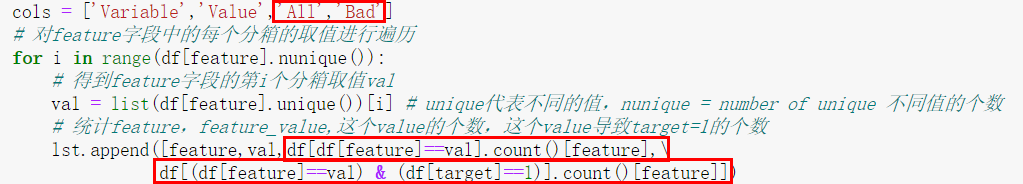
上面cal_IV(df,feature,target)中 All和Bad的解读

In [21]:
df = df_train
feature = 'bin_age'
val = list(df[feature].unique())[0]
print(val)
# 通过val做筛选实际上count有多个
df[df[feature]==val].count()
print(df[df[feature]==val].count())
count1 = df[df[feature]==val].count()[feature] # 和len(df[df[feature]==val]) 等同
print(count1)
count2 = len(df[df[feature]==val])
print(count2)

(40.0, 50.0]
SeriousDlqin2yrs                            35037
RevolvingUtilizationOfUnsecuredLines        35037
age                                         35037
NumberOfTime30-59DaysPastDueNotWorse        35037
DebtRatio                                   35037
MonthlyIncome                               35037
NumberOfOpenCreditLinesAndLoans             35037
NumberOfTimes90DaysLate                     35037
NumberRealEstateLoansOrLines                35037
NumberOfTime60-89DaysPastDueNotWorse        35037
NumberOfDependents                          35037
bin_age                                     35037
bin_NumberOfDependents                      35037
bin_NumberOfTime30-59DaysPastDueNotWorse    35037
bin_NumberOfTime60-89DaysPastDueNotWorse    35037
bin_NumberOfTimes90DaysLate                 35037
bin_RevolvingUtilizationOfUnsecuredLines    35037
bin_DebtRatio                               35037
bin_MonthlyIncome                           35037
bin_NumberOfOpenCreditLinesAndLoans  

In [22]:
# 将每个字段的IV值计算出来
for f in bin_cols:
    # 将iv值大于等于0.1的字段筛选出来
    if cal_IV(df_train,f,'SeriousDlqin2yrs') >= 0.1:
        print(f,cal_IV(df_train,f,'SeriousDlqin2yrs'))

bin_age 0.24041120302785982
bin_NumberOfTime30-59DaysPastDueNotWorse 0.492444774570198
bin_NumberOfTime60-89DaysPastDueNotWorse 0.2665587583516951
bin_NumberOfTimes90DaysLate 0.49160685733515563
bin_RevolvingUtilizationOfUnsecuredLines 1.0596188771423887


可以看出bin_RevolvingUtilizationOfUnsecuredLines 1.0596188771423887 的iv值居然大于1（一般大于0.5就是难以置信，需要确认了）<br/>
该字段的物理含义为 除房地产和汽车贷款等无分期付款债务外，信用卡和个人信用额度的总余额除以信贷限额（百分比）<br/>
最上面该字段的直方图可以看出 虽然绝大部分数据都是很小的数，但有很少的数据是极大的，比例要超过100%<br/>
从describe里也能看出来<br/>
count    150000.000000<br/>
mean          6.048438<br/>
std         249.755371<br/>
min           0.000000<br/>
25%           0.029867<br/>
50%           0.154181<br/>
75%           0.559046<br/>
max       50708.000000<br/>
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64<br/>

In [23]:
# 这个说明如果是很大的数的话是很容易导致违约的 这就是iv值很高的原因（有点类似于标签泄露）
df_train[df_train['RevolvingUtilizationOfUnsecuredLines'] > 1]['RevolvingUtilizationOfUnsecuredLines'].mean()

259.77336166149837

In [24]:
feature_cols = ['bin_age','bin_NumberOfTime30-59DaysPastDueNotWorse',\
                'bin_NumberOfTime60-89DaysPastDueNotWorse','bin_NumberOfTimes90DaysLate',\
               'bin_RevolvingUtilizationOfUnsecuredLines']

In [25]:
bin_cols

['bin_age',
 'bin_NumberOfDependents',
 'bin_NumberOfTime30-59DaysPastDueNotWorse',
 'bin_NumberOfTime60-89DaysPastDueNotWorse',
 'bin_NumberOfTimes90DaysLate',
 'bin_RevolvingUtilizationOfUnsecuredLines',
 'bin_DebtRatio',
 'bin_MonthlyIncome',
 'bin_NumberOfOpenCreditLinesAndLoans',
 'bin_NumberRealEstateLoansOrLines']

In [35]:
def cal_WOE(df,features,target):
    df_new = df.copy()
    for f in features:
        df_woe = df_new.groupby(f).agg({target:['sum','count']})
        df_woe.columns =  list(map(''.join,df_woe.columns.values))
        df_woe = df_woe.reset_index()
        df_woe = df_woe.rename(columns={target+'sum':'bad',target+'count':'all'})

        df_woe['good'] = df_woe['all'] - df_woe['bad']
        df_woe['margin bad'] = df_woe['bad'] / df_woe['bad'].sum()
        df_woe['margin good'] = df_woe['good'] / df_woe['good'].sum()
        # np.log1p 可以避免分母为0，出现负无穷的情况
        df_woe['woe'] = np.log1p(df_woe['margin bad'] / df_woe['margin good'])
        #print(df_woe)
        df_woe.columns = [c if c==f else c+'_'+f for c in list(df_woe.columns.values)]
        #print(df_woe)
        df_new = df_new.merge(df_woe,on=f,how='left')
    return df_new

# 计算这些特征的woe
df_woe = cal_WOE(df_train,bin_cols,'SeriousDlqin2yrs')

C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [27]:
df_woe

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,...,good_bin_NumberOfOpenCreditLinesAndLoans,margin bad_bin_NumberOfOpenCreditLinesAndLoans,margin good_bin_NumberOfOpenCreditLinesAndLoans,woe_bin_NumberOfOpenCreditLinesAndLoans,bad_bin_NumberRealEstateLoansOrLines,all_bin_NumberRealEstateLoansOrLines,good_bin_NumberRealEstateLoansOrLines,margin bad_bin_NumberRealEstateLoansOrLines,margin good_bin_NumberRealEstateLoansOrLines,woe_bin_NumberRealEstateLoansOrLines
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,...,25838,0.184121,0.184591,0.691873,419,3652,3233,0.041791,0.023097,1.032961
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,...,30556,0.309495,0.218298,0.882845,4672,56188,51516,0.465988,0.368040,0.818076
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,...,30556,0.309495,0.218298,0.882845,4672,56188,51516,0.465988,0.368040,0.818076
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,...,24972,0.156892,0.178405,0.630962,4672,56188,51516,0.465988,0.368040,0.818076
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,...,35145,0.201177,0.251082,0.588475,2748,52338,49590,0.274087,0.354280,0.573037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,...,30556,0.309495,0.218298,0.882845,2748,52338,49590,0.274087,0.354280,0.573037
149996,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,...,30556,0.309495,0.218298,0.882845,2748,52338,49590,0.274087,0.354280,0.573037
149997,0,0.246044,58,0,3870.000000,5400.0,18,0,1,0,...,25838,0.184121,0.184591,0.691873,2748,52338,49590,0.274087,0.354280,0.573037
149998,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,...,30556,0.309495,0.218298,0.882845,4672,56188,51516,0.465988,0.368040,0.818076


In [34]:
# 得到WOE的规则
feature_columns = ['age','NumberOfTime30-59DaysPastDueNotWorse',\
                'NumberOfTime60-89DaysPastDueNotWorse','NumberOfTimes90DaysLate',\
               'RevolvingUtilizationOfUnsecuredLines']

df_bin_to_woe = pd.DataFrame(columns=['features','bin','woe'])
for f in feature_columns:
    b = 'bin_' + f
    w = 'woe_bin_' + f
    # print(df_woe.columns)
    df = df_woe[[w,b]].drop_duplicates()
    df.columns = ['woe','bin']
    df['features'] = f
    df_bin_to_woe = pd.concat([df_bin_to_woe,df])
df_bin_to_woe

,features,bin,woe
0,age,"(40.0, 50.0]",0.813822
1,age,"(25.0, 40.0]",0.955231
5,age,"(70.0, inf]",0.279404
6,age,"(50.0, 60.0]",0.651655
15,age,"(60.0, 70.0]",0.406848
19,age,"(-inf, 25.0]",1.013134
0,NumberOfTime30-59DaysPastDueNotWorse,"(1.0, 2.0]",1.797837
1,NumberOfTime30-59DaysPastDueNotWorse,"(-inf, 1.0]",0.572521
13,NumberOfTime30-59DaysPastDueNotWorse,"(2.0, 3.0]",2.151185
183,NumberOfTime30-59DaysPastDueNotWorse,"(3.0, 4.0]",2.429111


In [29]:
woe_cols = [c for c in list(df_woe.columns.values) if 'woe' in c]
woe_cols

['woe_bin_age',
 'woe_bin_NumberOfDependents',
 'woe_bin_NumberOfTime30-59DaysPastDueNotWorse',
 'woe_bin_NumberOfTime60-89DaysPastDueNotWorse',
 'woe_bin_NumberOfTimes90DaysLate',
 'woe_bin_RevolvingUtilizationOfUnsecuredLines',
 'woe_bin_DebtRatio',
 'woe_bin_MonthlyIncome',
 'woe_bin_NumberOfOpenCreditLinesAndLoans',
 'woe_bin_NumberRealEstateLoansOrLines']

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,roc_auc_score

# 逻辑回归模型
x_train,x_test,y_train,y_test = train_test_split(df_woe[woe_cols],df_woe['SeriousDlqin2yrs'],test_size=0.2,random_state = 1234)
# 需要对原始数据算法进行调整将np.log改为np.log1p 防止分母为0，出现负无穷的情况
# 否则回报错：Input contains NaN,infinity or a value too large for dtype('float64')


In [37]:
x_train.describe() # x_train有缺失值

,woe_bin_age,woe_bin_NumberOfDependents,woe_bin_NumberOfTime30-59DaysPastDueNotWorse,woe_bin_NumberOfTime60-89DaysPastDueNotWorse,woe_bin_NumberOfTimes90DaysLate,woe_bin_RevolvingUtilizationOfUnsecuredLines,woe_bin_DebtRatio,woe_bin_MonthlyIncome,woe_bin_NumberOfOpenCreditLinesAndLoans,woe_bin_NumberRealEstateLoansOrLines
count,120000.000000,1.200000e+05,120000.000000,1.200000e+05,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000
mean,-0.114218,-inf,-0.143934,-inf,-0.115704,-0.462882,-0.024526,-0.024819,-0.020281,-0.026106
std,0.540454,NaN,0.487411,NaN,0.427343,0.998063,0.229496,0.237393,0.211014,0.243412
min,-1.132145,-inf,-0.257826,-inf,-0.176674,-1.447382,-0.201802,-0.390198,-0.221596,-0.256641
25%,-0.689003,-4.079102e-02,-0.257826,-9.799045e-02,-0.176674,-1.286617,-0.166025,-0.102701,-0.128496,-0.256641
50%,-0.084782,-4.079102e-02,-0.257826,-9.799045e-02,-0.176674,-0.866502,-0.097667,0.009843,-0.122389,-0.188639
75%,0.228343,-4.079102e-02,-0.257826,-9.799045e-02,-0.176674,0.053164,-0.084360,0.009843,-0.002550,0.235970
max,0.562024,4.585632e-01,2.846431,3.734887e+00,4.124352,1.242254,0.425358,0.347772,0.349083,0.592980


更改算法为np.log1p后

In [32]:
x_train.describe()

,woe_bin_age,woe_bin_NumberOfDependents,woe_bin_NumberOfTime30-59DaysPastDueNotWorse,woe_bin_NumberOfTime60-89DaysPastDueNotWorse,woe_bin_NumberOfTimes90DaysLate,woe_bin_RevolvingUtilizationOfUnsecuredLines,woe_bin_DebtRatio,woe_bin_MonthlyIncome,woe_bin_NumberOfOpenCreditLinesAndLoans,woe_bin_NumberRealEstateLoansOrLines
count,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000
mean,0.672975,0.691758,0.650119,0.672640,0.655034,0.603589,0.687506,0.687820,0.688603,0.687555
std,0.235122,0.060840,0.335375,0.242817,0.325581,0.480798,0.122284,0.117810,0.109729,0.124000
min,0.279404,0.000000,0.572521,0.000000,0.608707,0.211221,0.597328,0.516960,0.588475,0.573037
25%,0.406848,0.672960,0.572521,0.645352,0.608707,0.243890,0.613576,0.643114,0.630962,0.573037
50%,0.651655,0.672960,0.572521,0.645352,0.608707,0.350952,0.645506,0.698081,0.633824,0.603269
75%,0.813822,0.672960,0.572521,0.645352,0.608707,0.720083,0.651857,0.698081,0.691873,0.818076
max,1.013134,0.948487,2.902860,3.758483,4.140397,1.495914,0.928274,0.882076,0.882845,1.032961


In [33]:
model = LogisticRegression(random_state=1234).fit(x_train,y_train)
y_pred = model.predict(x_test)
print(accuracy_score(y_pred,y_test))
print(roc_auc_score(y_pred,y_test))

0.9359666666666666
0.7630527415671403
